In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchmetrics import Precision, Recall

from torchvision.datasets import ImageFolder
from torchvision import transforms

from torchmetrics import Accuracy

In [3]:
from zipfile import ZipFile 

# loading the temp.zip and creating a zip object 
with ZipFile("data/clouds.zip", 'r') as zObject: 
  
    # Extracting all the members of the zip  
    # into a specific location. 
    zObject.extractall(path=".") 

## Image dataset

##### Let's start with building a Torch Dataset of images. You'll use it to explore the data and, later, to feed it into a model.

##### The training data for the cloud classification task is stored in the following directory structure:

- clouds_train
  - cirriform clouds
    - 539cd1c356e9c14749988a12fdf6c515.jpg
    - ...
  - clear sky
  - cumulonimbus clouds
  - cumulus clouds
  - high cumuliform clouds
  - stratiform clouds
  - stratocumulus clouds

##### There are seven folders inside clouds_train, each representing one cloud type (or a clear sky). Inside each of these folders sit corresponding image files.

##### The following imports have already been done for you:

<code>
from torchvision.datasets import ImageFolder
from torchvision import transforms
</code>

### Instructions
-    Compose two transformations, the first, to parse the image to a tensor, and one to resize the image to 128 by 128, assigning them to train_transforms.
-    Use ImageFolder to define dataset_train, passing it the directory path to the data ("clouds_train") and the transforms defined earlier.

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [6]:
# Compose transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

# Create Dataset using ImageFolder
dataset_train = ImageFolder(
    "clouds/clouds_train",
    transform=train_transforms,
)

## Data augmentation in PyTorch

##### Let's include data augmentation in your Dataset and inspect some images visually to make sure the desired transformations are applied.

##### First, you'll add the augmenting transformations to train_transforms. Let's use a random horizontal flip and a rotation by a random angle between 0 and 45 degrees. The code that follows to create the Dataset and the DataLoader is exactly the same as before. Finally, you'll reshape the image and display it to see if the new augmenting transformations are visible.

##### All the imports you need have been called for you:

<code>
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
</code>

##### Time to augment some cloud photos!

### Instructions
-    Add two more transformations to train_transforms to perform a random horizontal flip and then a rotation by a random angle between 0 and 45 degrees.
-    Reshape the image tensor from the DataLoader to make it suitable for display.
-    Display the image.

In [7]:
import matplotlib.pyplot as plt

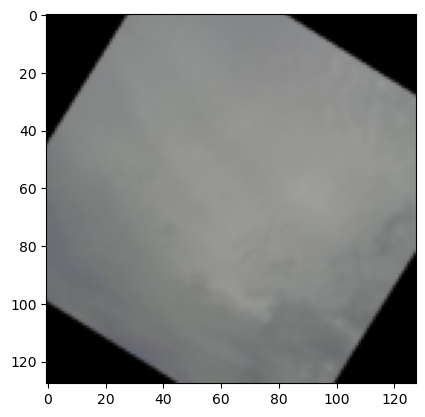

In [9]:
train_transforms = transforms.Compose([
    # Add horizontal flip and rotation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

dataset_train = ImageFolder(
  "clouds/clouds_train",
  transform=train_transforms,
)

dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=1
)

image, label = next(iter(dataloader_train))
# Reshape the image tensor
image = image.squeeze().permute(1, 2, 0) 
# Display the image
plt.imshow(image)
plt.show()

## Building convolutional networks

##### You are on a team building a weather forecasting system. As part of the system, cameras will be installed at various locations to take pictures of the sky. Your task is to build a model to classify different cloud types in these pictures, which will help spot approaching weather fronts.

##### You decide to build a convolutional image classifier. The model will consist of two parts:

##### -    A feature extractor that learns a vector of features from the input image,
##### -    A classifier that predicts the image's class based on the learned features.

##### Both torch and torch.nn as nn have already been imported for you, so let's get to it!

### Instructions 1/3
-    Define the feature_extractor part of the model by adding another convolutional layer with 64 output feature maps, the ELU activation, and a max pooling layer with a window of size two; at the end, flatten the output.

In [10]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )

### Instructions 2/3
-    Define the classifier part of the model as a single linear layer with a number of inputs that reflects an input image of 64x64 and the feature extractor defined; the classifier should have num_classes outputs.

In [11]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(64*16*16, num_classes)

### Instructions 3/3
-    In the forward() method, pass the input image x first through the feature extractor and then through the classifier.

In [12]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(64*16*16, num_classes)
    
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

## Dataset with augmentations

##### You have already built the image dataset from cloud pictures and the convolutional model to classify different cloud types. Before you train it, let's adapt the dataset by adding the augmentations that could improve the model's cloud classification performance.

##### The code to set up the Dataset and DataLoader is already prepared for you and should look familiar. Your task is to define the composition of transforms that will be applied to the input images as they are loaded.

##### Note that before you were resizing images to 128 by 128 to display them nicely, but now you will use smaller ones to speed up training. As you will see later, 64 by 64 will be large enough for the model to learn.

##### from torchvision import transforms has been already executed for you, so let's get to it!

### Instructions
-    Define train_transforms by composing together five transformations: a random horizontal flip, random rotation (by angle from 0 to 45 degrees), random automatic contrast adjustment, parsing to tensor, and resizing to 64 by 64 pixels.

In [13]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

dataset_train = ImageFolder(
  "clouds/clouds_train",
  transform=train_transforms,
)
dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=16
)

## Image classifier training loop

##### It's time to train the image classifier! You will use the Net you defined earlier and train it to distinguish between seven cloud types.

##### To define the loss and optimizer, you will need to use functions from torch.nn and torch.optim, imported for you as nn and optim, respectively. You don't need to change anything in the training loop itself: it's exactly like the ones you wrote before, with some additional logic to print the loss during training.

### Instructions
-    Define the model using your Net class with num_classes set to 7 and assign it to net.
-    Define the loss function as cross-entropy loss and assign it to criterion.
-    Define the optimizer as Adam, passing it the model's parameters and the learning rate of 0.001, and assign it to optimizer.
-    Start the training for-loop by iterating over training images and labels.

In [14]:
# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 1.9746
Epoch 2, Loss: 1.5689
Epoch 3, Loss: 1.4386


## Multi-class model evaluation

##### Let's evaluate our cloud classifier with precision and recall to see how well it can classify the seven cloud types. In this multi-class classification task it is important how you average the scores over classes. Recall that there four approaches:

-    Not averaging, and analyzing the results per class;
-    Micro-averaging, ignoring the classes and computing the metrics globally;
-    Macro-averaging, computing metrics per class and averaging them;
-    Weighted-averaging, just like macro but with the average weighted by class size.

##### Both Precision and Recall are already imported from torchmetrics. It's time to see how well our model is doing!

### Instructions 1/2
-        Define precision and recall metrics calculated globally on all examples.

In [19]:
from torchmetrics import Precision, Recall

dataset_test = ImageFolder(
  "clouds/clouds_test",
  transform=train_transforms,
)
dataloader_test = DataLoader(
  dataset_test, shuffle=True, batch_size=16
)

In [20]:
# Define metrics
metric_precision = Precision(task="multiclass", num_classes=7, average="micro")
metric_recall = Recall(task="multiclass", num_classes=7, average="micro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.3333333432674408
Recall: 0.3333333432674408


### Instructions 2/2
-    Change your code to compute separate recall and precision metrics for each class and average them with a simple average.

In [21]:
# Define metrics
metric_precision = Precision(task="multiclass", num_classes=7, average="macro")
metric_recall = Recall(task="multiclass", num_classes=7, average="macro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.4449162185192108
Recall: 0.29109954833984375


## Analyzing metrics per class

##### While aggregated metrics are useful indicators of the model's performance, it is often informative to look at the metrics per class. This could reveal classes for which the model underperforms.

##### In this exercise, you will run the evaluation loop again to get our cloud classifier's precision, but this time per-class. Then, you will map these score to the class names to interpret them. As usual, Precision has already been imported for you. Good luck!

### Instructions
-    Define a precision metric appropriate for per-class results.
-    Calculate the precision per class by finishing the dict comprehension, iterating over the .items() of the .class_to_idx attribute of dataset_test.

In [22]:
# Define precision metric
metric_precision = Precision(
    task="multiclass", num_classes=7, average=None
)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v 
    in dataset_test.class_to_idx.items()
}
print(precision_per_class)

{'cirriform_clouds': 0.3065326511859894, 'clear_sky': 0.8571428656578064, 'cumulonimbus_clouds': 0.800000011920929, 'cumulus_clouds': 0.739130437374115, 'high_cumuliform_clouds': 0.29955947399139404, 'stratiform_clouds': 0.0, 'stratocumulus_clouds': 0.0}
